In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(2)

In [3]:
# Import data
classes = 100
tf = [transforms.Grayscale()]
train = datasets.get_cifar(classes, transform=tf)
test = datasets.get_cifar(classes, transform=tf, train=False)

# Get data parameters
N = len(train)
M = np.prod(train.size)

# Set training parameters and loader
batch_size = 32
epochs = 25
nu = 0.0005
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'pie_conv_deblur'

In [4]:
# Generate Blur
blur = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur.weight.data[...] = 1/9
blur.weight.requires_grad = False;

# Generate GPU version
blur_gpu = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur_gpu.weight.data[...] = 1/9
blur_gpu.weight.requires_grad = False;
blur_gpu.to(device);

# Generate winsplit
split = modules.AdjointSequential(
    modules.AdjointPatchSplitter((4,4), (8,8)),
    modules.AdjointFlatten(-2, -1, (4,4))
)

In [5]:
# Initialize dimensions, models, parameters and optimizers

dims = [1, 3, 6, 3, 1]
kernels =  [3, 5, 5, 3]

model_kwargs = {
    'activation': modules.BiCELU,
    'activation_params': {},
    'device': device,
    'init': nn.init.orthogonal_
}

nets = {
    "PIE": models.conv.AdjointConv(
        dims,
        kernels,
        diagonal=False,
        **model_kwargs,
    ),
    "PIELD": models.conv.AdjointConv(
        dims,
        kernels,
        diagonal='diag',
        size=(32, 32),
        **model_kwargs,
    ),
    "PIESD": models.conv.AdjointConv(
        dims,
        kernels,
        diagonal='sep',
        size=(32, 32),
        **model_kwargs,
    ),
    "AE": models.conv.AEConv(
        dims,
        kernels,
        diagonal=False,
        **model_kwargs,
    ),
}

for k, model in nets.items():
    loss_trace[k] = {}
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)
    

In [6]:
# Define objective function

def objective_function(x, xh, y, yh, params=None, l2_lambda=1e-6, reduction='mean'):
    losses = {}
    
    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    kwargs = {'reduction': reduction, 'alpha': 6.0}
    
    losses['lx'] = utils.loss.logcosh(xh, x, **kwargs)
    losses['ly'] = utils.loss.logcosh(yh, y, **kwargs)
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [7]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:8}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params PIE     :  967
No. params PIELD   :  4039
No. params PIESD   :  1031
No. params AE      :  1934


In [8]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.cat([train[k][0] for k in sample_indices_small])
xs = xims.to(device)[:,None,...]
ys = blur_gpu(xs)
xt = torch.cat([test[k][0] for k in range(len(test))])[:,None,...]
yt = blur(xt).to(device)
xt = xt.to(device)

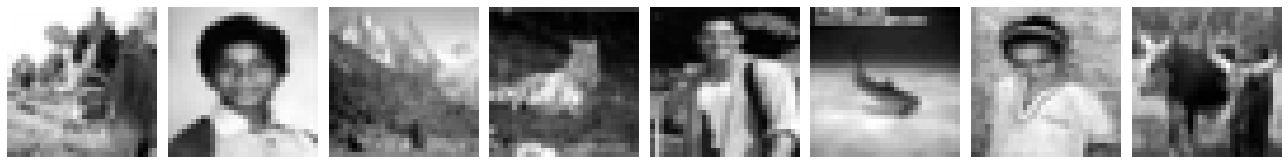

In [9]:
fig, ax = plt.subplots(1, 8, figsize=(18,8))
for i in range(8):
    ax[i].imshow(xims[i], cmap='gray')

for a in ax:
    a.grid(False)
    a.axis('off')

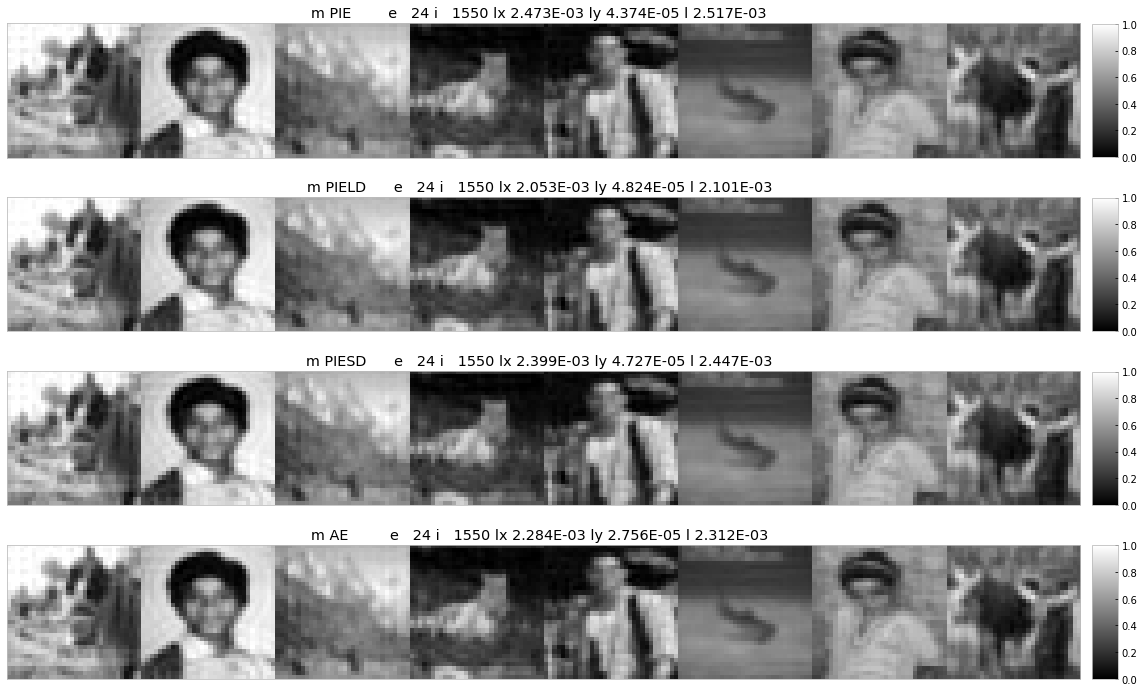

In [10]:
# Training loop

for e in range(epochs):
    i = 0
    for x, _ in loader:
        y = blur(x).to(device).detach()
        x = x.to(device)
                
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()            
            yh = nets[cur](x)
            xh = nets[cur].T(y)

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh, y, yh)

            loss.backward()
            opts[cur].step()

#             # Validation
#             with torch.no_grad():
#                 yth = nets[cur](xt)
#                 xth = nets[cur].T(yt)
#                 ldicts[cur]['lt'] = utils.loss.logcosh(xth, xt, alpha=6.0, reduction='mean')
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 50 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    xhs[cur] = nets[cur].T(ys).cpu()[:,0,...]
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, path=experiment_name, cmap='gray')
            
        i += 1

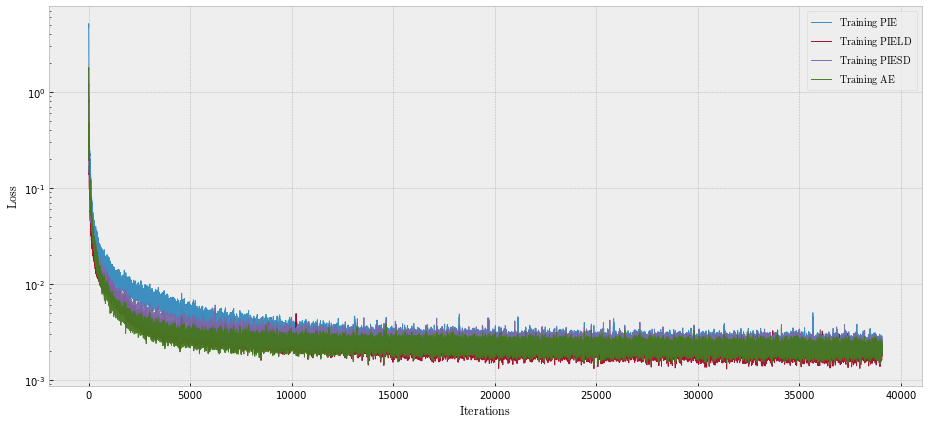

In [11]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    plt.plot(np_loss_trace[k]["l"], linewidth=1, label=f"$\mathrm{{Training\,\,{k}}}$", alpha=0.95)

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
#plt.ylim(0.005, 0.05)
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

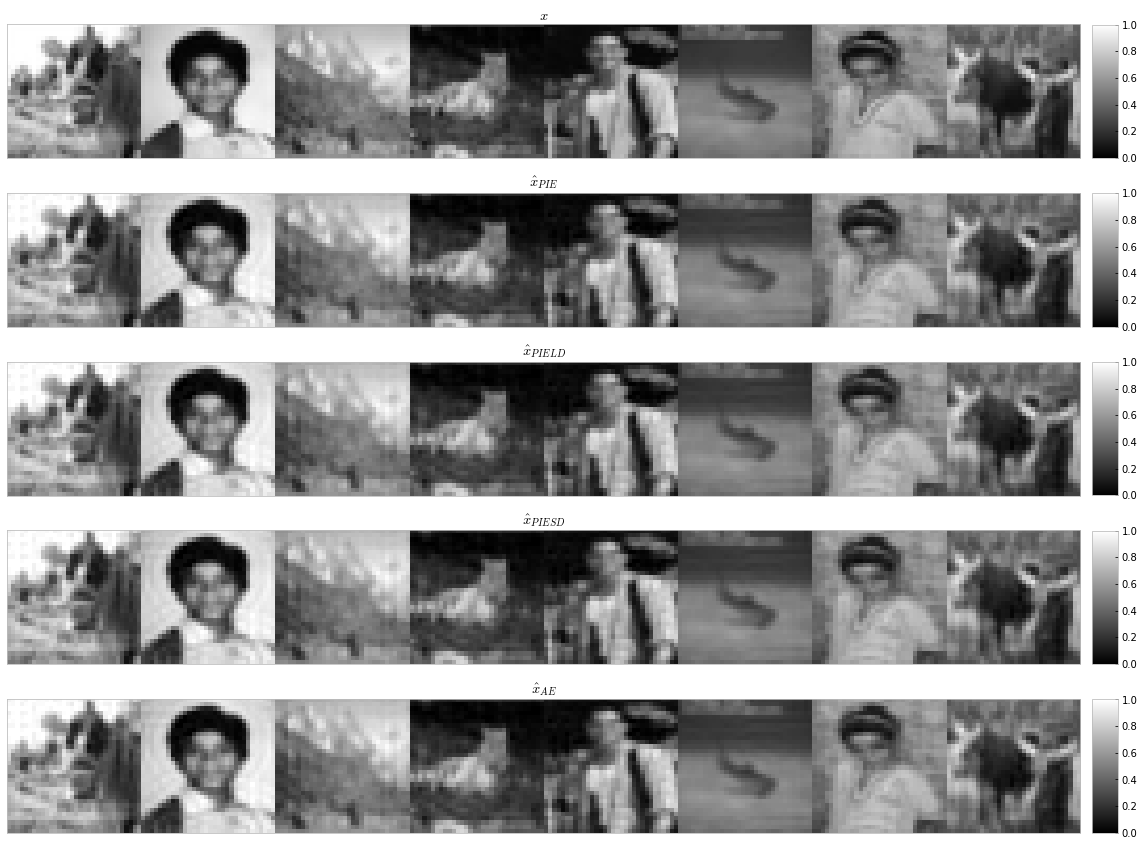

In [12]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to(device)
    
# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for k in nets.keys():
        xhs[k] = nets[cur].T(ys).cpu()[:,0,...]
    
utils.reporting.plot_results(xhs, '', fname=experiment_name, cmap='gray')

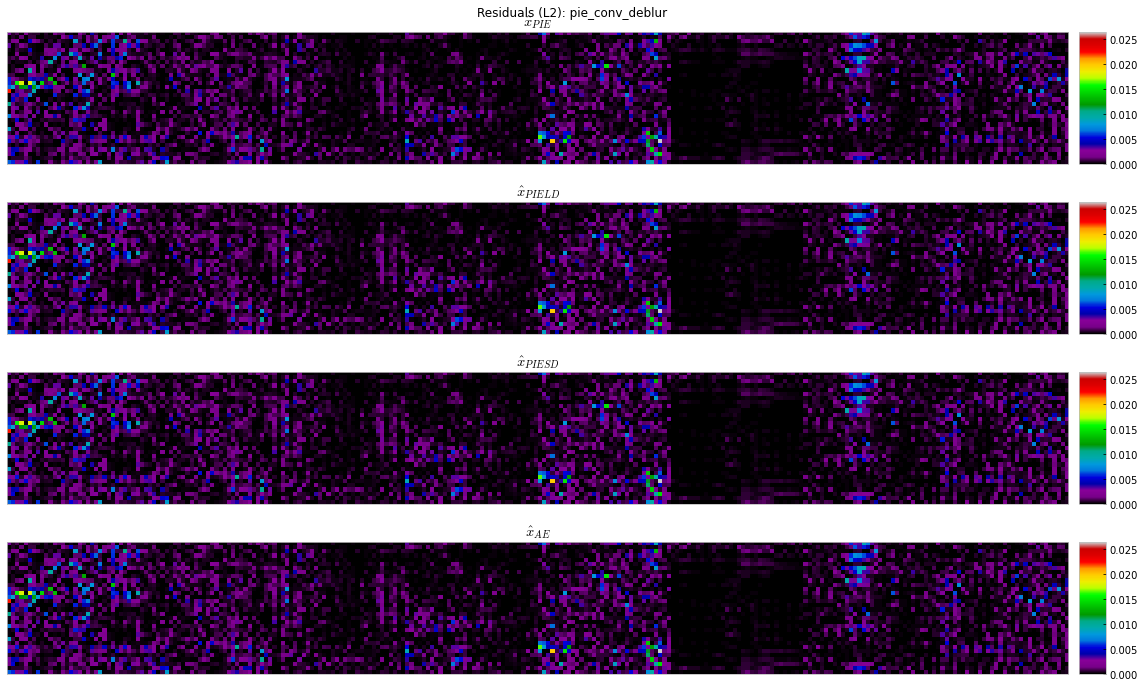

In [13]:
# Plot residuals (L2)
with torch.no_grad():
    xhs = {}
    curmax = 0

    for k in nets.keys():
        xhs[k] = nets[cur].T(nets[cur](xs)).cpu()[:,0,...]
        xhs[k] = (xhs[k] - xims)**2
        if torch.max(xhs[k]) > curmax:
            curmax = torch.max(xhs[k])

utils.reporting.plot_results(
    xhs, f'Residuals (L2): {experiment_name}', vmax=curmax, fname=experiment_name + 'res', root='../figures/results/'
)

In [14]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    del model
    
torch.cuda.empty_cache()

In [15]:
# Compute test tensor
test_tensor = xt.cpu()

In [16]:
# Calculate relative error on test data

print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(yt.cpu())
        YH = model(xt.cpu())
        re_x = utils.metrics.relative_error(XH, xt.cpu(), reduction='mean')
        re_y = utils.metrics.relative_error(YH, yt.cpu(), reduction='mean')
        mse_x = F.mse_loss(XH, xt.cpu(), reduction='mean')
        mse_y = F.mse_loss(YH, yt.cpu(), reduction='mean')
    print(
        f"{k:6}: " + 
        f"REx {re_x:4E} " +
        f"REy {re_y:4E} " +
        f"RE  {(re_x + re_y) / 2:4E} " +
        f"MSEx {mse_x:4E} " + 
        f"MSEy {mse_y:4E} " +
        f"MSE  {(mse_x + mse_y) / 2:4E} "
    )

Relative Error:
PIE   : REx 5.921637E-02 REy 8.518117E-03 RE  3.386724E-02 MSEx 7.970552E-04 MSEy 1.430232E-05 MSE  4.056788E-04 
PIELD : REx 5.647664E-02 REy 1.034554E-02 RE  3.341109E-02 MSEx 6.876969E-04 MSEy 1.898159E-05 MSE  3.533392E-04 
PIESD : REx 5.908084E-02 REy 8.728845E-03 RE  3.390484E-02 MSEx 7.718655E-04 MSEy 1.306684E-05 MSE  3.924662E-04 
AE    : REx 5.687575E-02 REy 9.871119E-03 RE  3.337343E-02 MSEx 7.225173E-04 MSEy 2.053105E-05 MSE  3.715242E-04 


In [17]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(yt.cpu())
        YH = model(xt.cpu())
        psnr_x = utils.metrics.psnr(xt.cpu(), XH)
        ssim_x = utils.metrics.ssim(
            xt.cpu(), 
            XH
        )
        psnr_y = utils.metrics.psnr(yt.cpu(), YH)
        ssim_y = utils.metrics.ssim(
            yt.cpu(), 
            YH
        )
    print(
        f"{k:6}: " + 
        f"PSNRx: {psnr_x:4E} " +
        f"PSNRy: {psnr_y:4E} " +
        f"PSNR:  {(psnr_y + psnr_x) / 2:4E} " +
        f"SSIMx: {ssim_x:4E} " +
        f"SSIMy: {ssim_y:4E} " +
        f"SSIM:  {(ssim_y + ssim_x) / 2:4E} "
    )

Image Reconstruction Metrics:
PIE   : PSNRx: 3.098512E+01 PSNRy: 4.844593E+01 PSNR:  3.971552E+01 SSIMx: 9.645742E-01 SSIMy: 9.988250E-01 SSIM:  9.816996E-01 
PIELD : PSNRx: 3.162603E+01 PSNRy: 4.721667E+01 PSNR:  3.942135E+01 SSIMx: 9.694318E-01 SSIMy: 9.987692E-01 SSIM:  9.841005E-01 
PIESD : PSNRx: 3.112458E+01 PSNRy: 4.883829E+01 PSNR:  3.998144E+01 SSIMx: 9.645404E-01 SSIMy: 9.984316E-01 SSIM:  9.814860E-01 
AE    : PSNRx: 3.141152E+01 PSNRy: 4.687589E+01 PSNR:  3.914370E+01 SSIMx: 9.662771E-01 SSIMy: 9.998072E-01 SSIM:  9.830422E-01 


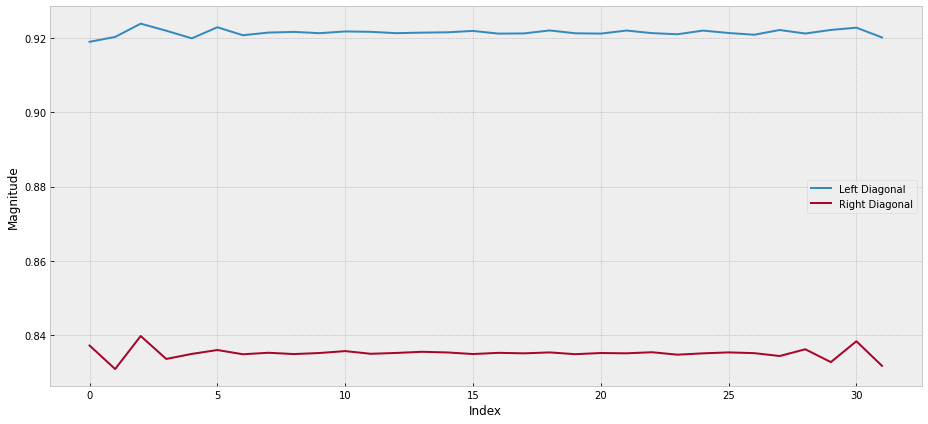

In [18]:
plt.plot(nets['PIESD'].net.D.weight_m.data, label='Left Diagonal')
plt.plot(nets['PIESD'].net.D.weight_n.data, label='Right Diagonal')
plt.legend()
plt.xlabel('Index');
plt.ylabel('Magnitude');

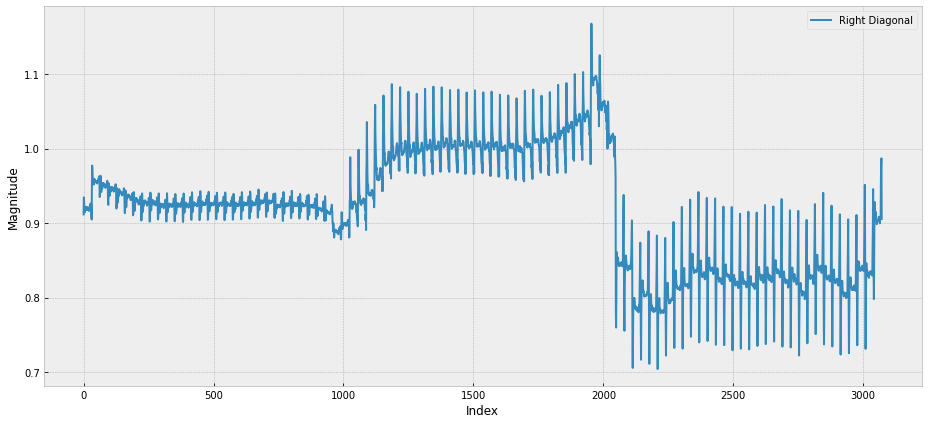

In [19]:
plt.plot(nets['PIELD'].net.D.diag.weight.data, label='Right Diagonal')
plt.legend()
plt.xlabel('Index');
plt.ylabel('Magnitude');

In [20]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphix': [], 'lphiy': []}
    rs[k] = nn.Parameter(torch.randn(1, 32, 32).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [21]:
# Define Perturbation Objective
def perturbation_objective(xe, xh, ye, yh):
    losses = {}
    
    lphix = -F.mse_loss(xe, xh)
    losses['lphix'] = lphix
    lphiy = -F.mse_loss(ye, yh)
    losses['lphiy'] = lphiy

    return sum(losses.values()), losses

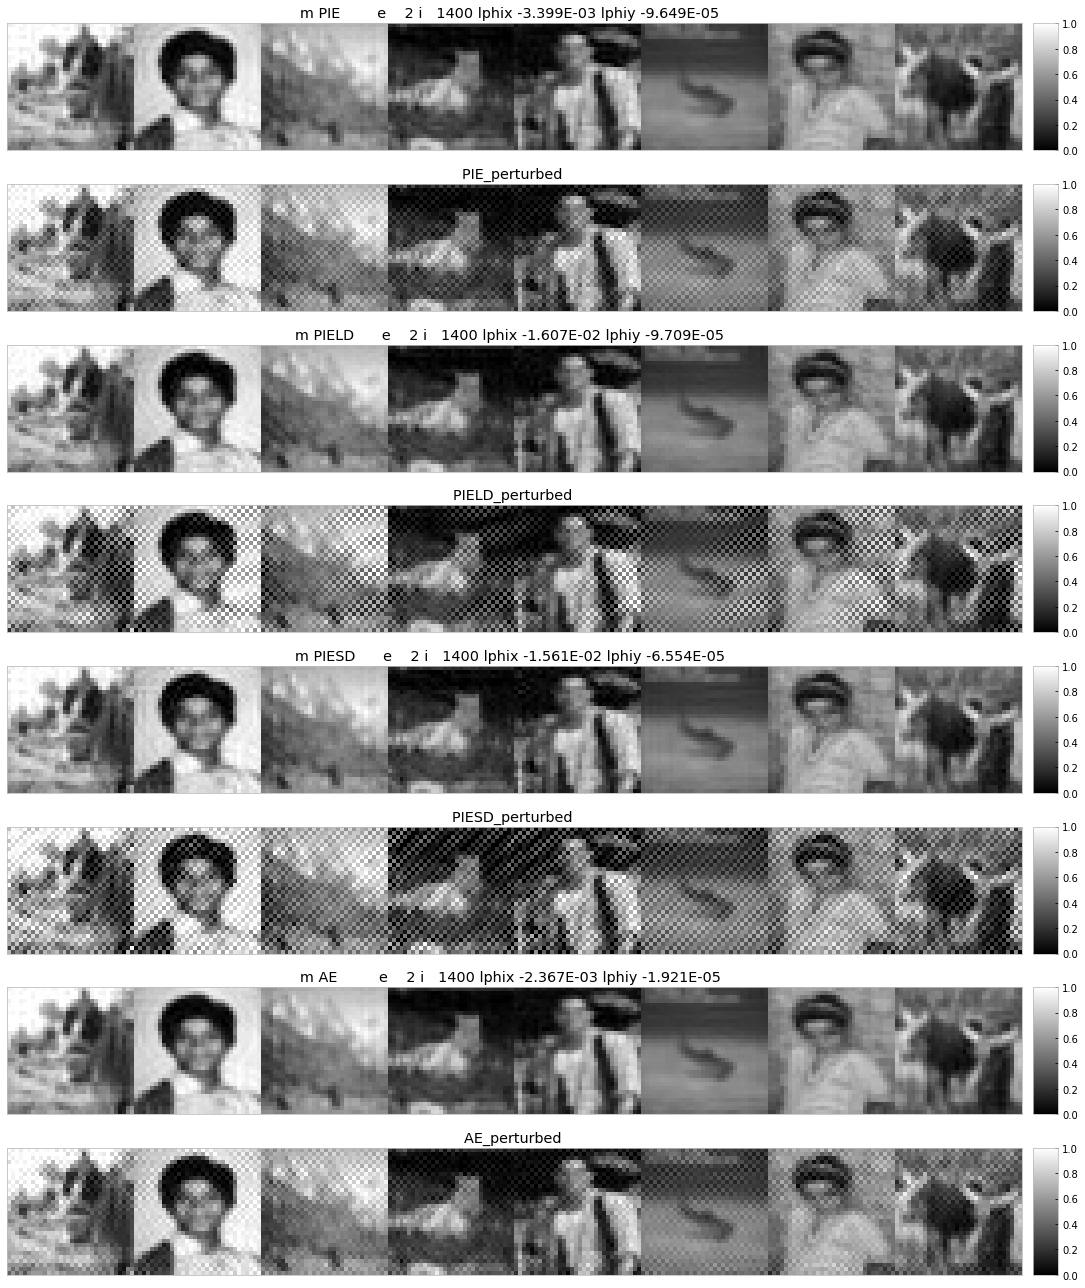

In [22]:
# Training loop

for e in range(3):
    i = 0
    for x, _ in loader:
        y = blur(x).to(device).detach()
        x = x.to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1, 32, 32))

            yh = nets[cur](x)
            ye = nets[cur](x + r)
            xh = nets[cur].T(yh)
            xe = nets[cur].T(ye)
            
            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh, ye, yh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 200 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (32, 32))

                    xhs[cur] = nets[cur].T(nets[cur](xs)).cpu()[:,0,...]
                    xhs[per] = nets[cur].T(nets[cur](xs + r)).cpu()[:,0,...]
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

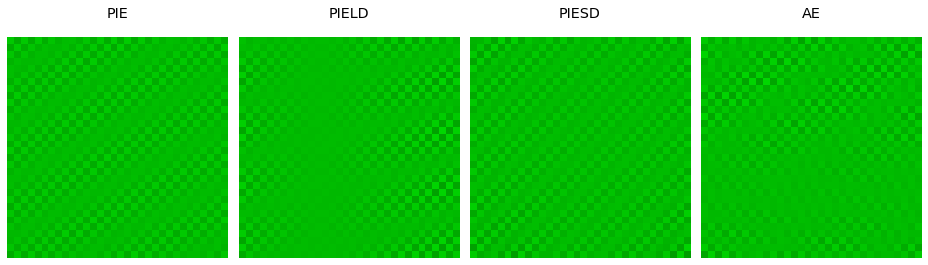

In [23]:
fig, ax = plt.subplots(1, 4)
for i, (k, r) in enumerate(rs.items()):
    r = utils.projection.project_into_ball(rs[k].flatten(-3, -1), 1, 2).unflatten(-1, (1, 32, 32))
    ax[i].matshow(
        r.cpu().detach()[0,...], 
        vmin=-1, 
        vmax=1
    )
    ax[i].grid(False)
    ax[i].axis('off')
    ax[i].set_title(k)

plt.savefig(f'../figures/misc/{experiment_name}_perturbationvecs.pdf')

In [24]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

# Calculate relative error
print(f"Relative Error:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[k].flatten(-3, -1), 1, 2).unflatten(-1, (1, 32, 32)).cpu()
        XE = model.T(model(test_tensor + r))

    print(f"{k:6}: {utils.metrics.relative_error(test_tensor + r, XE, reduction='mean')}")

print(f"Relative Cond:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[k].flatten(-3, -1), 1, 2).unflatten(-1, (1, 32, 32)).cpu()
        XE = model.T(model(test_tensor + r))
        XH = model.T(model(test_tensor))

    rerr_psi = utils.metrics.relative_error(XH, XE, reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor, test_tensor + r, reduction='mean')
    cond_no = utils.metrics.relative_cond_no(
        XH.flatten(-3, -1), 
        XE.flatten(-3, -1),
        test_tensor.flatten(-3, -1),
        r.flatten(-3, -1),
        reduction='mean'
    )
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Error:
PIE   : 0.09095755219459534
PIELD : 0.2562348246574402
PIESD : 0.25610992312431335
AE    : 0.07010374963283539
Relative Cond:
PIE   : 0.138010 0.079486 6.480605
PIELD : 0.292809 0.077808 13.928114
PIESD : 0.322571 0.080150 14.241448
AE    : 0.103998 0.074686 5.280428


In [25]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [26]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)

In [10]:
# Load models

nets = {'PIE':None, 'PIELD': None, 'PIESD': None, 'AE':None}

serialized_path = f'../serialized/experiments/{experiment_name}/'
for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'rb') as outfile:
        nets[name] = torch.load(outfile)

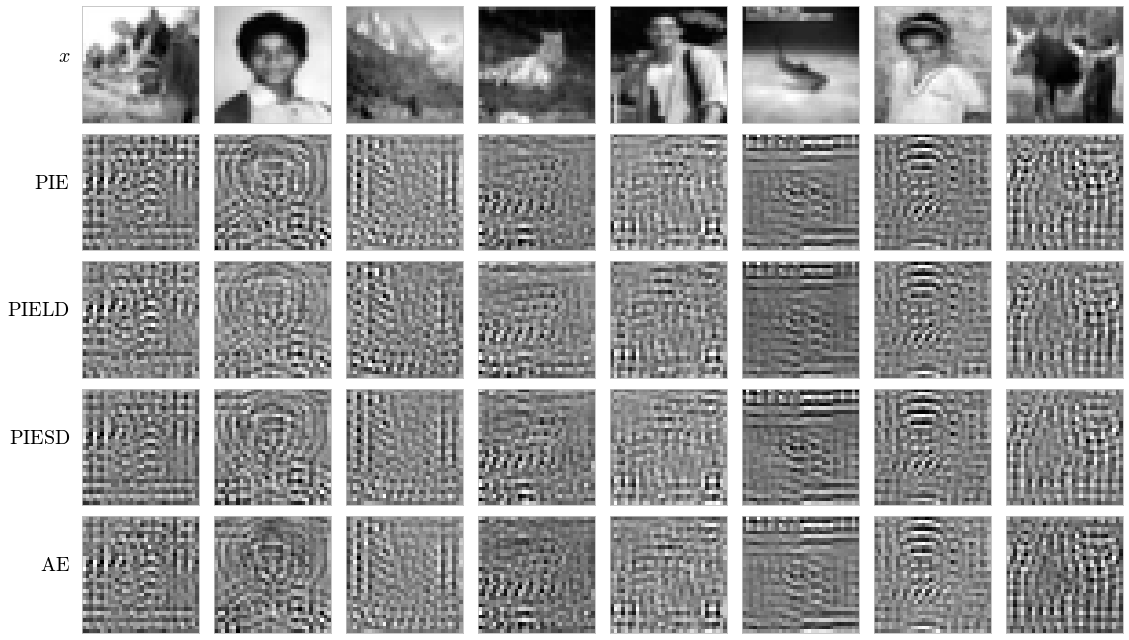

In [11]:
fig, ax = plt.subplots(len(nets)+1, 8, figsize=(16,9))

for j, cur in enumerate(nets):
    _xx = xs.clone().cpu()
    _yy = ys.clone().cpu()
    _xx.requires_grad = True
    _yy.requires_grad = True

    nets[cur].zero_grad()
    _xxh = nets[cur].T(_yy.cpu())
    _yyh = nets[cur](_xx.cpu())
    loss, _ = objective_function(_xx, _xxh, _yy, _yyh)
    loss.backward()
    ax[j+1,0].set_ylabel(f'$\\mathrm{{{cur}}}$', fontsize=20, rotation=0, ha='right', labelpad=12)
    for i in range(8):
        ax[j+1,i].matshow(_xx.grad[i,0].detach(), cmap='gray')
        ax[j+1,i].grid(False)
        ax[j+1,i].tick_params(
            axis='both',
            which='both',
            bottom=False,
            left=False,
            top=False, 
            right=False, 
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False,
        )

ax[0,0].set_ylabel(f'$x$', fontsize=20, rotation=0, ha='right', labelpad=12)
for i in range(8):
    ax[0,i].matshow(_xx[i,0].detach(), cmap='gray')
    ax[0,i].grid(False)
    ax[0,i].tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        top=False, 
        right=False, 
        labelbottom=False,
        labelleft=False,
        labelright=False,
        labeltop=False,
    )

plt.savefig(f'../figures/misc/{experiment_name}_gradients.pdf')

In [12]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphix': [], 'lphiy': []}
    rs[k] = nn.Parameter(torch.randn(1, 32, 32).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [13]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphix = -F.mse_loss(xe, xh)
    losses['lphix'] = lphix

    return sum(losses.values()), losses

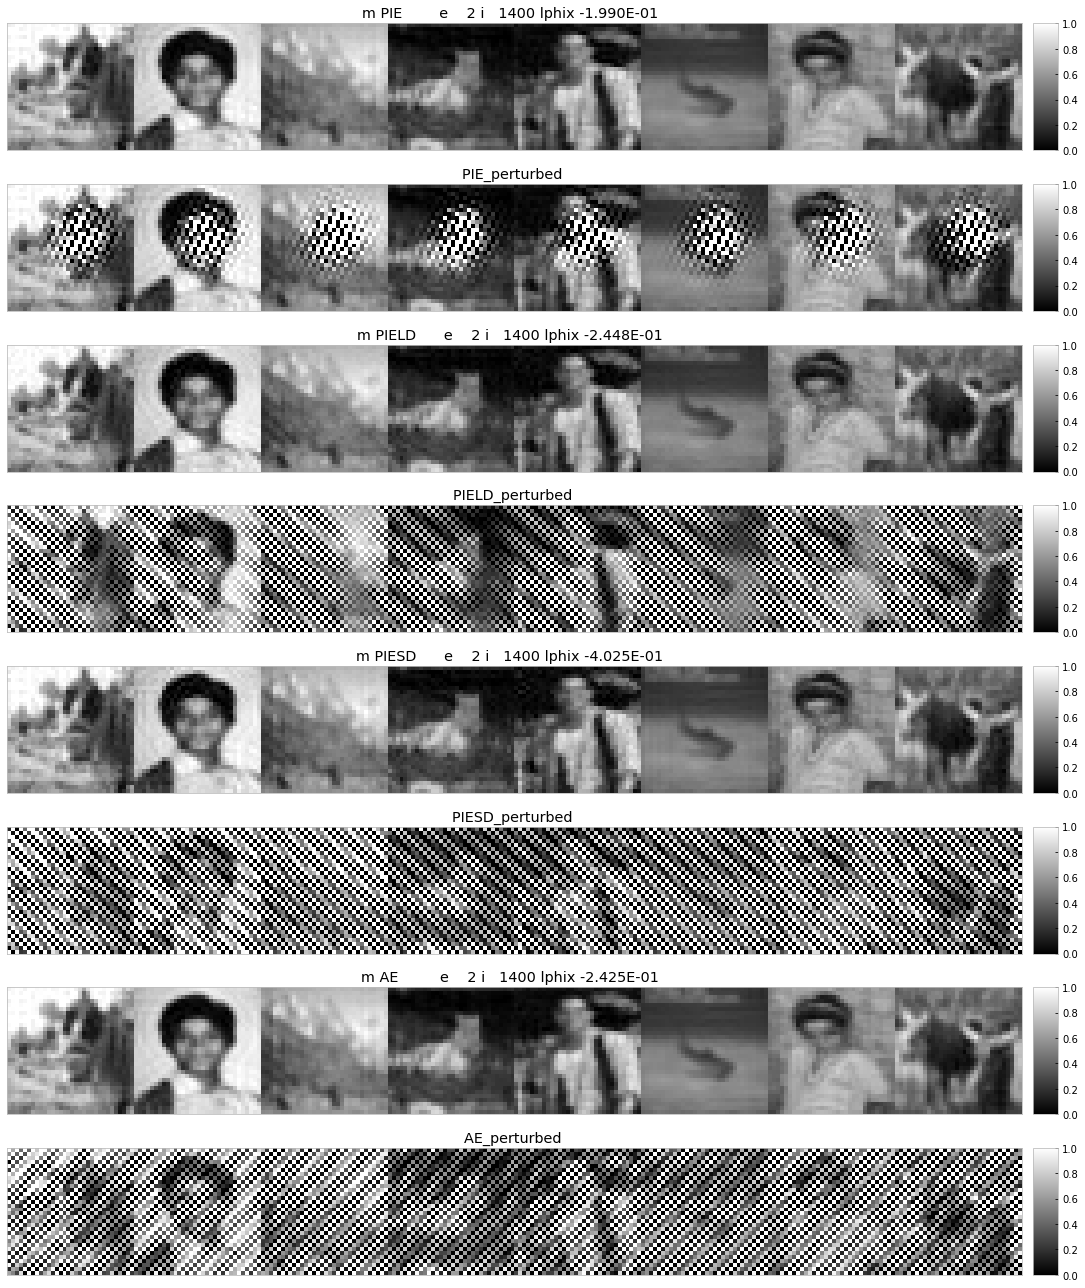

In [14]:
# Training loop

for e in range(3):
    i = 0
    for x, _ in loader:
        y = blur(x).to(device).detach()
        x = x.to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1, 32, 32))

            xh = nets[cur].T(y)
            xe = nets[cur].T(y + r)
            
            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 200 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (32, 32))

                    xhs[cur] = nets[cur].T(nets[cur](xs)).cpu()[:,0,...]
                    xhs[per] = nets[cur].T(nets[cur](xs) + r).cpu()[:,0,...]
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

In [15]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1, 32, 32)).cpu()
        XH = nets[k].T(yt.cpu() + r)
        XE = nets[k].T(yt.cpu())
        

    cond_no = utils.metrics.relative_cond_no(
        XH.flatten(-3, -1), 
        XE.flatten(-3, -1),
        yt.flatten(-3, -1).cpu(),
        r.flatten(-3, -1),
        reduction='mean'
    )
    
    print(f"{k:6}: {cond_no.item():2.6f}")

Relative Cond:
PIE   : 15.544894
PIELD : 31.596514
PIESD : 36.827427
AE    : 37.333912
